*Awadhesh kumar

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import mstats
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [25]:
df = pd.read_csv('/content/dataset_model (1).csv')
pd.set_option('display.max_rows', df.shape[0]+1)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [0]:
#Removing Unique Variable
uni_Var = [i for i in df.columns if df[i].unique().size == df.shape[0]]
df = df.drop(uni_Var, axis=1)

In [0]:
#Removing Target Variable
tar_Var = df['Loan_Status']
df = df.drop(columns='Loan_Status')

**Detecting and Handling Outlier**

In [0]:
cont_data = df._get_numeric_data().columns
cont_data = cont_data.drop(['Loan_Amount_Term', 'Credit_History'])
cat_data = list(set(df.columns) - set(cont_data))

In [29]:
#We consider a variable as a outlier if it lies outside of third standard deviation of the column. 
#Given below the number of outlier in each column
thrs = 3
out = []
for i in cont_data:
  out.clear()
  print(i)
  mean = np.mean(df[i])
  std = np.std(df[i])
  for j in df[i]:
    z = (j - mean)/std
    if np.abs(z) > thrs:
      out.append(z)
  print(out)

ApplicantIncome
[3.0143095050697597, 5.667623383716305, 7.594863718885357, 4.659606571212465, 5.528044263896173, 9.490977255033487, 12.384622787173148, 5.294101795465248]
CoapplicantIncome
[3.1967125462128783, 3.3102609013326325, 6.285775026458728, 6.285775026458728, 11.018210537880542, 13.696173250494027]
LoanAmount
[5.8888825374459675, 5.304189848804997, 6.473575226086938, 4.076335202658959, 3.3863978300626143, 3.900927396066668, 4.017865933794862, 4.953374235620415, 3.023888363105213, 4.134804471523056, 3.900927396066668, 3.900927396066668, 5.304189848804997, 4.088029056431779]


**Handling Outlier

 1.Winsorizing**

In [30]:
df_win = df.copy()
df_win[cont_data].skew()

ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.677552
dtype: float64

In [12]:
for i in cont_data:
  df_win[i] = mstats.winsorize(df_win[i], limits=[0.05,0.1])
df_win.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,5849,0.0,267.0,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [31]:
df_win[cont_data].skew()

ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.677552
dtype: float64

**Handling Missing Values**

In [32]:
miss_data=[]
for i in df_win.columns:
  if df_win[i].isnull().sum() > 0:
    miss_data.append(i)
miss_data.remove('Loan_Amount_Term')
miss_data

['Gender',
 'Married',
 'Dependents',
 'Self_Employed',
 'LoanAmount',
 'Credit_History']

In [33]:
#Using mode for categorical data, and interpolate for numerical value, as it gives more accuracy in the model
for i in miss_data:
  df_win[i] = df_win[i].fillna(df_win[i].mode()[0])
df_win[miss_data]
df_win['Loan_Amount_Term'] = df_win['Loan_Amount_Term'].fillna(df_win['Loan_Amount_Term'].interpolate())
df_win.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,No,0,Graduate,No,5849,0.0,120.0,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


**Encoding
1.Target Variable**

In [34]:
lE = LabelEncoder()
en_Tar_Var = pd.DataFrame(lE.fit_transform(tar_Var))
en_Tar_Var.columns =(['Loan_Status'])
en_Tar_Var.head()

,Loan_Status
0,1
1,0
2,1
3,1
4,1


In [35]:
df_win_lE = df_win.copy()
df_win_lE.shape

(614, 11)

In [36]:
for i in cat_data:
  df_win_lE[i] = lE.fit_transform(df_win_lE[i])
df_win_lE.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,0,0,0,0,5849,0.0,120.0,10,1,2
1,1,1,1,0,0,4583,1508.0,128.0,10,1,0
2,1,1,0,0,1,3000,0.0,66.0,10,1,2
3,1,1,0,1,0,2583,2358.0,120.0,10,1,2
4,1,0,0,0,0,6000,0.0,141.0,10,1,2


In [37]:
df_win_lE.shape

(614, 11)

**Splitting Data**

In [0]:
#Splitting in 20% as test size and 80% as train size
X_train, X_test, y_train, y_test = train_test_split(df_win_lE, en_Tar_Var, test_size=0.20, random_state=42, stratify=en_Tar_Var)

**Logistic Regression**

In [0]:
#Training on default parameter
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

**Using RandomSearchCV
1.To get the best combination of the parameter**

In [0]:
#RandomSearchCV

para=[{
       'multi_class':['auto','ovr', 'multinomial'],
       'class_weight':['Balanced'],
       'l1_ratio' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
       'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
       'dual':[True, False],
       'max_iter':[50,100,200,250, 1000]}
      ]

rSCV = RandomizedSearchCV(log_reg, param_distributions=para, n_iter=50, cv=4, n_jobs=-1)

rSCV.fit(X_train, y_train)
y_pred1 = rSCV.predict(X_test)

In [41]:
print("Confusion Matrix:\n"+str(confusion_matrix(y_test, y_pred1)))
print("Accuracy of Dtree Model:")
print("%.2f"%round(accuracy_score(y_test, y_pred1)*100,2) + '%')
print("Precision of DTree Model:")
print ("%.2f" % round(precision_score(y_test, y_pred1)*100) + '%')
print ("Recall of DTree Model:" )
print("%.2f" % round(recall_score(y_test, y_pred1)*100) + '%')
print ("F1 Score of DTree Model:")
print ("%.2f" % round(f1_score(y_test, y_pred1)*100) + '%')

Confusion Matrix:
[[22 16]
 [ 1 84]]
Accuracy of Dtree Model:
86.18%
Precision of DTree Model:
84.00%
Recall of DTree Model:
99.00%
F1 Score of DTree Model:
91.00%


In [43]:
print("Auroc Value:\n"+str(round(roc_auc_score(y_test,y_pred1)*100)) + '%')

Auroc Value:
78.0%


**AUROC curve for LogisticRegression with LabelEncoder Dataset**

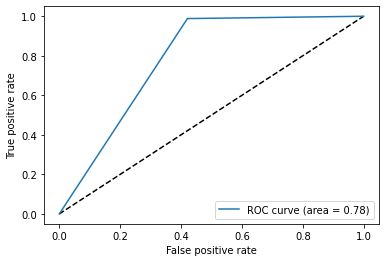

In [44]:
fpr, tpr, thresholds = roc_curve(y_test,y_pred1)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% roc_auc_score(y_test,y_pred1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

**Random Forest Classifier**

In [0]:
rFC = RandomForestClassifier(random_state=50)
rFC.fit(X_train, y_train)

In [0]:
from scipy.stats import randint
para_rFC=[{'n_estimators':[100,200,300,400,500],
       'criterion' : ['gini','entropy'],
       'max_depth' : [2,3,5,10,30,50],
       'bootstrap' : [True,False],
       'min_samples_leaf' : randint(1,4),
       'oob_score' : [True,False],
       'class_weight' : ['balanced', 'balanced-subsample']}]

rSCV2 = RandomizedSearchCV(rFC, param_distributions=para_rFC, n_iter=40, cv=4, n_jobs=-1)
rSCV2.fit(X_train, y_train)
y_pred2 = rSCV2.predict(X_test)

In [47]:
print("Confusion Matrix:\n"+str(confusion_matrix(y_test, y_pred2)))
print("Accuracy of Dtree Model:")
print("%.2f"%round(accuracy_score(y_test, y_pred2)*100,2) + '%')
print("Precision of DTree Model:")
print ("%.2f" % round(precision_score(y_test, y_pred2)*100) + '%')
print ("Recall of DTree Model:" )
print("%.2f" % round(recall_score(y_test, y_pred2)*100) + '%')
print ("F1 Score of DTree Model:")
print ("%.2f" % round(f1_score(y_test, y_pred2)*100) + '%')

Confusion Matrix:
[[22 16]
 [ 2 83]]
Accuracy of Dtree Model:
85.37%
Precision of DTree Model:
84.00%
Recall of DTree Model:
98.00%
F1 Score of DTree Model:
90.00%


**AUROC curve for RandomForestClassifier with LabelEncoded Dataset**

AUROC Value:
78.0%


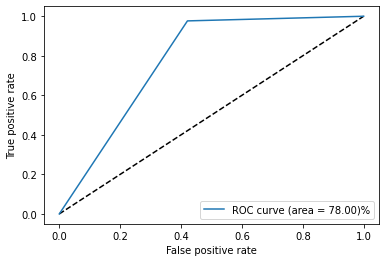

In [48]:
print("AUROC Value:\n"+str(round(roc_auc_score(y_test,y_pred2)*100)) + '%')
fpr, tpr, thresholds = roc_curve(y_test,y_pred2)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% round(roc_auc_score(y_test,y_pred2)*100) + '%')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

**OneHot Encoding**

In [49]:
df_win_oHE = df_win.copy()
for i in cat_data:
  df_win_oHE = pd.get_dummies(df_win_oHE, columns=[i], prefix=[i])
df_win_oHE.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History_0.0,Credit_History_1.0,Gender_Female,Gender_Male,Married_No,Married_Yes,Loan_Amount_Term_12.0,Loan_Amount_Term_36.0,Loan_Amount_Term_60.0,Loan_Amount_Term_84.0,Loan_Amount_Term_120.0,Loan_Amount_Term_180.0,Loan_Amount_Term_240.0,Loan_Amount_Term_270.0,Loan_Amount_Term_300.0,Loan_Amount_Term_330.0,Loan_Amount_Term_360.0,Loan_Amount_Term_420.0,Loan_Amount_Term_480.0,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes
0,5849,0.0,120.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0
1,4583,1508.0,128.0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0
2,3000,0.0,66.0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1
3,2583,2358.0,120.0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,1,0
4,6000,0.0,141.0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0


In [50]:
df_win_oHE.shape

(614, 33)

**Spliting of Data**

In [0]:
#Splitting the dataset into 25% as test_set, 75% as train size
X_train_oHE, X_test_oHE, y_train_oHE, y_test_oHE = train_test_split(df_win_oHE, en_Tar_Var, test_size=0.25, random_state=42, stratify=en_Tar_Var)

**Logistic Regression**

In [0]:
#Training on default parameter
log_reg.fit(X_train_oHE, y_train_oHE)
y_pred3 = log_reg.predict(X_test_oHE)
accuracy_score(y_test_oHE, y_pred3)

Using RandomSearchCV
1.To get the best combination of the parameter

**Using RandomSearchCV instead of GridSearchCV as it is faster than GridSearchCV**

In [54]:
#RandomSearchCV

para=[{
       'multi_class':['auto','ovr', 'multinomial'],
       'l1_ratio' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
       'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
       'penalty':['l1', 'l2', 'elacticnet'],
       'dual':[True, False],
       'max_iter':[50,100,200,250,1000],
       'fit_intercept': [True,False],
       'random_state' : [50]}
      ]

rSCV = RandomizedSearchCV(log_reg, param_distributions=para, n_iter=40, cv=5, n_jobs=-1)

rSCV.fit(X_train_oHE, y_train_oHE)
y_pred3 = rSCV.predict(X_test_oHE)
accuracy_score(y_test_oHE, y_pred3)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8571428571428571


As we can see that the accuracy after peforming RandomSearchCV is same as before. So, 0.827 is the best accuracy

In [55]:
print("Confusion Matrix:\n"+str(confusion_matrix(y_test_oHE, y_pred3)))
print("Accuracy of Dtree Model:")
print("%.2f"%round(accuracy_score(y_test_oHE, y_pred3)*100,2) + '%')
print("Precision of DTree Model:")
print ("%.2f" % round(precision_score(y_test_oHE, y_pred3)*100) + '%')
print ("Recall of DTree Model:" )
print("%.2f" % round(recall_score(y_test_oHE, y_pred3)*100) + '%')
print ("F1 Score of DTree Model:")
print ("%.2f" % round(f1_score(y_test_oHE, y_pred3)*100) + '%')

Confusion Matrix:
[[ 28  20]
 [  2 104]]
Accuracy of Dtree Model:
85.71%
Precision of DTree Model:
84.00%
Recall of DTree Model:
98.00%
F1 Score of DTree Model:
90.00%


**AUROC curve for LogisticRegression with OneHotEncoded Datase**

AUROC Value:
78.0%


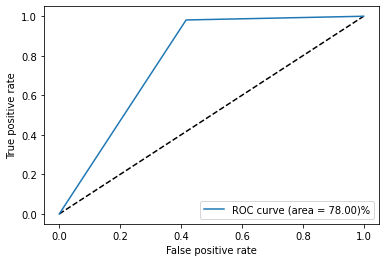

In [56]:
print("AUROC Value:\n"+str(round(roc_auc_score(y_test_oHE,y_pred3)*100)) + '%')
fpr, tpr, thresholds = roc_curve(y_test_oHE,y_pred3)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% round(roc_auc_score(y_test_oHE,y_pred3)*100) + '%')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

**Random Forest Classifier**

In [57]:
#Training model on default Parameters
rFC.fit(X_train_oHE, y_train_oHE)
y_pred4 = rFC.predict(X_test_oHE)
accuracy_score(y_test_oHE, y_pred4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8376623376623377

In [0]:
#Finding best combination of parameters in-order to get the maximum accuracy using RandomSearchCV
from scipy.stats import randint
para_rFC=[{'n_estimators':[100,200,300,400,500],
       'criterion' : ['gini','entropy'],
       'max_depth' : [2,3,5,10,30,50],
       'bootstrap' : [True,False],
       'min_samples_leaf' : randint(1,4),
       'oob_score' : [True,False],
       'class_weight' : ['balanced', 'balanced-subsample']}]

rSCV2 = RandomizedSearchCV(rFC, param_distributions=para_rFC, n_iter=40, cv=4, n_jobs=-1)
rSCV2.fit(X_train_oHE, y_train_oHE)
y_pred4 = rSCV2.predict(X_test_oHE)
accuracy_score(y_test_oHE,y_pred4)

In [59]:
print("Confusion Matrix:\n"+str(confusion_matrix(y_test_oHE, y_pred4)))
print("Accuracy of Dtree Model:")
print("%.2f"%round(accuracy_score(y_test_oHE, y_pred4)*100,2) + '%')
print("Precision of DTree Model:")
print ("%.2f" % round(precision_score(y_test_oHE, y_pred4)*100) + '%')
print ("Recall of DTree Model:" )
print("%.2f" % round(recall_score(y_test_oHE, y_pred4)*100) + '%')
print ("F1 Score of DTree Model:")
print ("%.2f" % round(f1_score(y_test_oHE, y_pred4)*100) + '%')

Confusion Matrix:
[[ 27  21]
 [  1 105]]
Accuracy of Dtree Model:
85.71%
Precision of DTree Model:
83.00%
Recall of DTree Model:
99.00%
F1 Score of DTree Model:
91.00%


**AUROC curve for RandomForestClassifier with OneHotEncoded Dataset**

AUROC Value:
78.0%


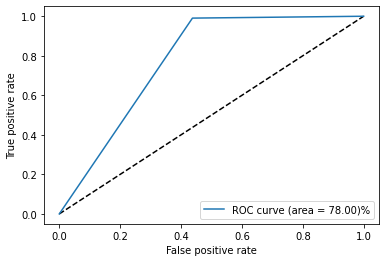

In [60]:
print("AUROC Value:\n"+str(round(roc_auc_score(y_test_oHE,y_pred4)*100)) + '%')
fpr, tpr, thresholds = roc_curve(y_test_oHE,y_pred4)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)'% round(roc_auc_score(y_test_oHE,y_pred4)*100) + '%')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')


Conclusion
1.Label Encoded Dataset

Using 80% of the data as train_set.

a. Logistic Regression -

 Accuracy - 85.37%

b. RandomForest Classifier -

Accuracy - 86.18%                                                              2.OneHot Encoded Dataset

Using 75% of data as Train_Set

a. Logistic Regression -

Accuracy - 85.71%

b. RandomForest Clasifier -

Accuracy - 85.06%
As we can see in LabelEncoded Dataset

    - RandomForest Classifier has more accuracy